# Data Privatization 

In this notebook we show how you can use the privatization method by [Amazon scientists](https://www.amazon.science/blog/preserving-privacy-in-analyses-of-textual-data) privatize a dataset. 

We will work with the Dutch Book Review Dataset. In order to efficiently execute the data privatization algorithm, we will leverage the annoy library for nearest neighbour search and the PySpark library for parallel computing.

# Introduction

The main idea of the privatization algorithm is to replace privacy sensitive text with semantically similar words. This is done by moving in the word embedding space from the original word towards a carefully crafted noise vector and obtaining a new word. In the example below, the word "phone" is replaced with the word "mobile". The technique is a form of differential privacy that perturbs data in such
 a way that adversaries can't claim with certainty whether a particular sentence originated from a user, or was the result of a perturbation.

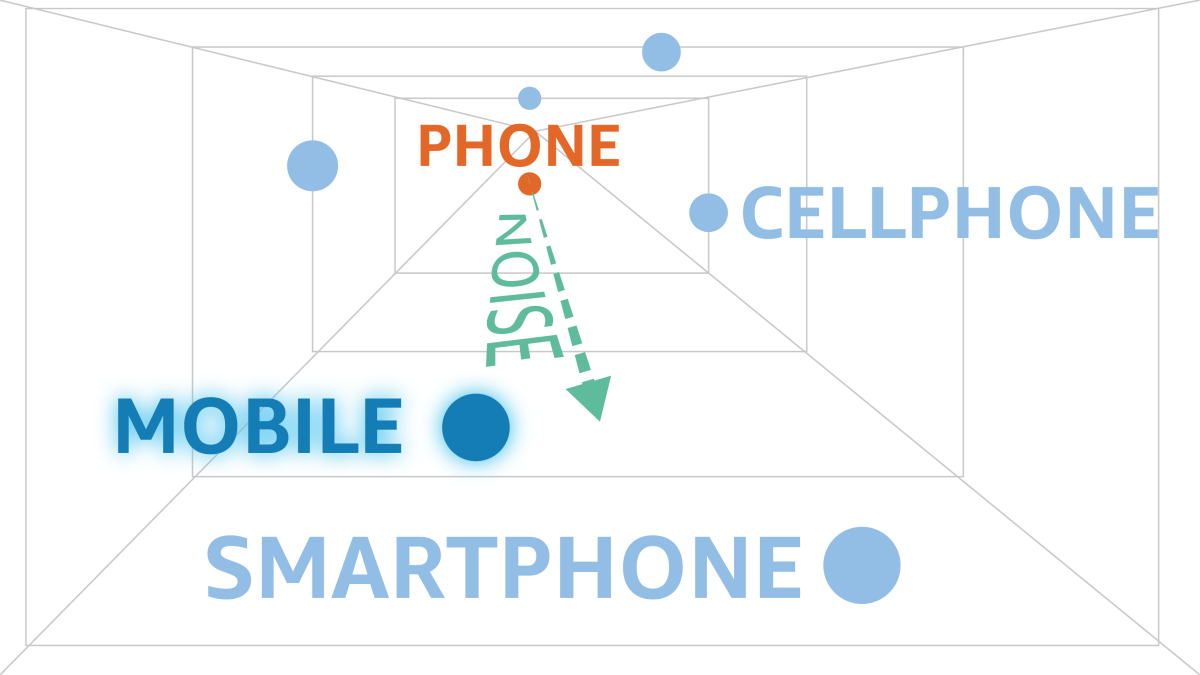

Image Source: https://www.amazon.science/blog/preserving-privacy-in-analyses-of-textual-data

# 1. Setup

## 1.1. Use Colab GPU for Training

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [ ]:
import torch

# set global seed
torch.manual_seed(42)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.2. Install annoy

Next we install the annoy library. The annoy library helps us find nearest vectors quickly.

In [ ]:
!pip install annoy

## 1.3. Setting up PySpark in Colab

Spark is written in the Scala programming language and requires the Java Virutal Machine (JVM) to run. Therefore, our first task is to download Java. It will help us to do the nearest neighbour computings parallel. For info why PySpark is useful, click [here](https://moviecultists.com/why-we-use-parallelize-in-spark).

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Next, we will install Apache Spark 3.0.1 with Hadoop 2.7.

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

Now, we just need to unzip that folder.

In [ ]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

There is one last thing that we need to install and that is the findspark library. It will locate Spark on the system and import it as a regular library.

In [ ]:
!pip install -q findspark

Now that we have install all the necessary dependencies in Colab, it is time to set the environment path. This will enable us to run PySpark in the Colab environment.

In [ ]:
# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

We need to locate Spark in the system. For that, we import findspark and use findspark.init() method.

In [ ]:
import findspark
findspark.init()

## 1.4. Install the Hugging Face Library

Next, we  install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. We've selected the pytorch interface because it strikes a nice balance betwee nthe high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to a specific task. For example, in this notebook we will use ``` BertForSequenceClassification```.



In [ ]:
!pip install transformers

In [ ]:
!pip install torchtext==0.9.0

# 2. Loading Data

## 2.1. Dutch Book Review Dataset

We'll use the [Dutch Book Review Dataset (DBRD)](https://github.com/benjaminvdb/DBRD) to be privatized. It's a set of reviews labeled as positive or negative.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Here we make TabularDataset of our data. This way we can create a vocabulary and add the fine-tuned Dutch fastText model.

In [ ]:
import torch
from torchtext.legacy import data

# give filepath
filepath = 'gdrive/My Drive/Colab Data/MSc thesis/dbrd_preprocessed/complete_data.csv'

# prepare sensitive data
TEXT = data.Field(sequential=True, include_lengths=True)

LABEL = data.LabelField(dtype=torch.float)

fields = [('title', None),
          ('sentiment', LABEL),
          ('review', TEXT)]

# make tabular dataset
reviews = data.TabularDataset(
    path=filepath, format='csv',
    fields=fields,
    skip_header=True)

Next we collect a vocabulary of words that occurs in the dataset. There is a distinction between the phrase count created for word2vec and fastText, because word2vec is only trained on uncased words and fastText has been trained on cased words. 

The meaning of the word 'Parijs' is sensitive for capitalization in fastText and not in word2vec.

In [ ]:
from collections import Counter
import re

def create_counter(input_data, add_space_split=False, w2v=False):
    phrase_count = Counter()
    for example in input_data:
      review = example.review
      original_text = " ".join(review)
      text = original_text.replace(
          " ' ", "").replace("'", "").replace("/", " ").replace("  ", " ").replace('"', '')
      if add_space_split:
        text = re.split('\!|\,|\n|\.|\?|\-|\;|\:|\(|\)|\s', text)
      else:
        text = re.split('\!|\,|\n|\.|\?|\-|\;|\:|\(|\)', text)
      sentences = [x.strip() for x in text if x.strip()]
      if w2v:
        for sentence in sentences:
          phrase_count[sentence.lower()] += 1
      else:
        for sentence in sentences:
          phrase_count[sentence] += 1
    return phrase_count

Next we create counts and compare the size for word2vec and fastText.

In [ ]:
phrase_count = create_counter(reviews, add_space_split=True)
phrase_count_w2v = create_counter(reviews, add_space_split=True, w2v=True)

The size of the vocabulary, when sensitive to capitalization (fastText):

In [ ]:
len(phrase_count)

144695

The size of the vocabulary, when not sensitive to capitalization (word2vec):

In [ ]:
len(phrase_count_w2v)

129461

## 2.2. Embedding Models

### 2.2.1. word2vec (Option 1)

Load the Dutch fine-tuned word2vec embedding model.

In [ ]:
from torchtext.vocab import Vectors

# load embeddings using torchtext
# vectors = Vectors('gdrive/My Drive/Colab Data/MSc thesis/word2vec/word2vec_coosto') # file created by gensim
vectors_w2v = Vectors('gdrive/My Drive/Colab Data/MSc thesis/word2vec/combined-320.txt')

100%|██████████| 1442950/1442950 [02:10<00:00, 11016.74it/s]


In [ ]:
# compute list of all words in word embedding model
words_list_w2v = []
for i in range(vectors_w2v.__len__()):
  words_list_w2v.append(vectors_w2v.itos[i])

In [ ]:
len(words_list_w2v)

1442950

### 2.2.2. fastText (Option 2)

Load the Dutch fine-tuned fastText embedding model.

In [ ]:
from torchtext.vocab import Vectors

# attach fastText embeddings
vectors_ft = Vectors('gdrive/My Drive/Colab Data/MSc thesis/fastText/cc.nl.300.vec.gz')

100%|██████████| 2000000/2000000 [03:21<00:00, 9901.90it/s]


In [ ]:
words_list_ft = []
for i in range(vectors_ft.__len__()):
  words_list_ft.append(vectors_ft.itos[i])
len(words_list_ft)

2000000

### 2.2.3. BERT (Option 3)

In order to obtain contextual embedding, we have to load the BERTje tokenizer and model.

In [ ]:
from transformers import AutoTokenizer

# Load the BERTje tokenizer
print('Loading BERTje tokenizer...')
BERT_tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

Loading BERTje tokenizer...


Downloading:   0%|          | 0.00/254 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModel

# load pre-trained model (weights)
BERT_model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased",
                                  output_hidden_states = True, # whether the model returns all hidden-states
                                  )

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.poole

Note that the BERTje model is cased, which means that it is sensitive to capitalization of words. The word 'parijs' does not exist, whereas the word 'Parijs' does. Just as with fastText this is again in contrast with the word2vec model, where everything is lowercase (uncased).

In [ ]:
bertje_tokens = []
for token in BERT_tokenizer.vocab.keys():
  bertje_tokens.append(token)

len(bertje_tokens)

30073

## 2.3. Build Vocab for Embedding Models



In order to gain a somewhat fair comparison between the static embedding models, word2vec and fastText, we make a list of words that occur in both the embedding model and the vocabulary. Otherwise a performance advantage could be inherent to fastText as it has 2 million words and word2vec has 1.44 million words.

In [ ]:
vocab_words = list(phrase_count.keys())
vocab_words_w2v = list(phrase_count_w2v.keys())

The number of words that occur in the dataset and are in the word2vec embeddings model:

In [ ]:
intersect_w2v = list(set(words_list_w2v).intersection(vocab_words_w2v))
len(intersect_w2v)

94400

The number of words that occur in the dataset and are in the fastText embeddings model:

In [ ]:
intersect_ft = list(set(words_list_ft).intersection(vocab_words))
len(intersect_ft)

107708

Now we finally make the vocabularies for the word embedding models.

In [ ]:
from collections import defaultdict, Counter
from torchtext.vocab import Vocab

def vocab_counter(words):
  """
  Create a counter that holds all the words that intersect in the word2vec and fasttext vocab.
  """ 
  vocab_counter = Counter()
  for word in words:
    vocab_counter[word] += 1
  return vocab_counter

# create counter for the list of intersecting words
w2v_count = vocab_counter(intersect_w2v)

# create word2vec vocab
w2v_vocab = Vocab(counter=w2v_count)
w2v_vocab.load_vectors(vectors_w2v)

# create counter for fastText
ft_count = vocab_counter(intersect_ft)

# create fasttext vocab
ft_vocab = Vocab(counter=ft_count)
ft_vocab.load_vectors(vectors_ft)

# create counter for BERT tokens
bert_count = vocab_counter(bertje_tokens)

# create BERT vocab
BERT_vocab = Vocab(counter=bert_count)
BERT_vocab.set_vectors(BERT_tokenizer.vocab, BERT_model.embeddings.word_embeddings.weight.data, dim = 768)


## 2.4. Build Annoy Index

We use the annoy library to build an annoy index in order find the nearest vectors quickly. The reason we use Annoy, is because we only need to build the index once, and can pass this index in a parallel computing environment such as PySpark.

We define a function that creates an AnnoyIndex and saves it for later use, for a specified embedding model.

In [ ]:
from os.path import join
from annoy import AnnoyIndex

def build_AnnoyIndex(emb_vocab, emb_model, embedding_dims, num_trees=50):
  """
  Build AnnoyIndex for a specified embedding model and a vocabulary
  """
  # create approximate nearest neighbor index
  ann_index = AnnoyIndex(embedding_dims, 'euclidean')

  # initialize annoy index file name
  ann_title = 'M1_index_' + emb_model + '.ann'
  ann_filename = join('gdrive/My Drive/Colab Data/MSc thesis/Annoy Index/', ann_title)

  # add all word vectors in pretrained emb model
  for vector_num, vector in enumerate(emb_vocab.vectors):
      ann_index.add_item(vector_num, vector)

  print("Building annoy index...")
  # num_trees affects the build time and the index size
  # larger value will give more accurate results, but larger indexes
  assert ann_index.build(num_trees)
  ann_index.save(ann_filename)
  print("Annoy index built")

  return ann_filename, ann_index

### 2.4.1. Annoy Index word2vec


In [ ]:
# build ann index for word2vec model
emb_model = 'word2vec'
embedding_dims = 320
w2v_ann_filename, w2v_ann_index = build_AnnoyIndex(w2v_vocab, emb_model, embedding_dims)

w2v_ann_index.get_n_items()

Building annoy index...
Annoy index built


94402

In the word2vec model the 10 nearest neighbours of the word 'parijs' are:

In [ ]:
word = 'parijs'

word_index = w2v_vocab.stoi[word]
indices = w2v_ann_index.get_nns_by_item(word_index, 10)

for i in indices:
  print(w2v_vocab.itos[i])

parijs
straatsburg
parijse
lyon
bordeaux
brussel
montpellier
marseille
rennes
genève


### 2.4.2. Annoy Index fastText

In [ ]:
# build ann index for fasttext model
emb_model = 'fastText'
embedding_dims = 300
ft_ann_filename, ft_ann_index = build_AnnoyIndex(ft_vocab, emb_model, embedding_dims)

ft_ann_index.get_n_items()

Building annoy index...
Annoy index built


107710

In the fastText model the 10 nearest neighbours of the word 'parijs' are:

In [ ]:
word = 'Parijs'

word_index = ft_vocab.stoi[word]
indices = ft_ann_index.get_nns_by_item(word_index, 10)

for i in indices:
  print(ft_vocab.itos[i])

Parijs
Londen
Brussel
Berlijn
Barcelona
Bordeaux
Toulouse
Frankfurt
NewYork
Rotterdam


### 2.4.3. Annoy Index BERT

In [ ]:
# initialize model params
emb_model = 'BERT'
embedding_dims = 768

# create annoy index
BERT_ann_filename, BERT_ann_index = build_AnnoyIndex(BERT_vocab, emb_model, embedding_dims)

# print number of vectors in annoy index
BERT_ann_index.get_n_items()

Building annoy index...
Annoy index built


30075

In the BERT model the 10 nearest neighbour of the word 'Parijs' are:

In [ ]:
word = 'Parijs'

word_index = BERT_vocab.stoi[word] 
indices = BERT_ann_index.get_nns_by_item(word_index, 10)

for i in indices:
  print(BERT_vocab.itos[i])

Parijs
Frankrijk
Londen
Franse
Brussel
Berlijn
Amsterdam
Barcelona
Rotterdam
Rome


# 3. Privatization algorithm implementation


The steps of the algorithm are as follows:
* For each word in the dataset:
  * Obtain word's embedding vector μ. (In case of the static embedding models, check if word vector exists, otherwise return original word. In case of contextual BERT, create contextual word vector.)
  * Generate a noisy vector $N$. The parameter ```epsilon```  determines the amount of noise added.
  * Retrieve the embedding closest to the noisy vector μ + $N$.
  * Get the word that correpsonds to the closest vector.
  * Replace the original word with the retrieved word closest to the noisy vector.

## 3.1. Utility functions

### 3.1.1. Generate noise

In order to generate a noisy vector $N$, we define the following function.

In [ ]:
import numpy as np

# generate noise vector
def generate_laplacian_noise_vector(dimension, sensitivity, epsilon):
  """
  Generates noise to the provided vector dimension and epsilon value.
  """
  # sample normalized random normal vector
  rand_vec = np.random.normal(size=dimension)
  normalized_vec = rand_vec / np.linalg.norm(rand_vec)

  # sample magnituded from gamma distribution
  magnitude = np.random.gamma(shape=dimension, scale=sensitivity / epsilon)
  
  return normalized_vec * magnitude

### 3.1.2. Replace word by nearest to noise

In order to retrieve the embedding closest to the noisy vector μ + $N$ and retrieving the word corresponding to that embedding, we define the following functions.

#### 3.1.2.1. Static Replace



In [ ]:
def replace_word(sensitive_word, vocab, ann_index, epsilon, embedding_dims, sensitivity=1.0):
    """
    Replace a word by injecting noise according to the provided epsilon value 
    and return a perturbed word.
    """
    # turn word into lowercase for word2vec
    if embedding_dims == 320:
      sensitive_word = sensitive_word.lower()

    # generate a noise vector
    noise = generate_laplacian_noise_vector(embedding_dims, sensitivity, epsilon)

    # obtain vector of sensitive word
    original_vec = vocab.vectors[vocab.stoi[sensitive_word]]

    # obtain perturbed vector
    noisy_vector = original_vec + noise

    # obtain item closest to noisy vector
    closest_item = ann_index.get_nns_by_vector(noisy_vector, 1)[0]

    # check if word is out of vocab
    # if word is out of vocab return the original word
    if vocab.__getitem__(sensitive_word) != 0:
      privatized_word = vocab.itos[closest_item]
    else:
      privatized_word = sensitive_word

    return privatized_word

#### word2vec: small example how the word replace mechanism works

In [ ]:
word = 'Parijs'
epsilon = 150
embedding_dims = 320

for i in range(10):
  print(replace_word(word, w2v_vocab, w2v_ann_index, epsilon, embedding_dims))

ferrare
parijs
oervervelend
parijs
antibes
cerdan
daladier
solotentoonstellingen
parijs
parijs


In [ ]:
sensitive_sent = 'Ik ga wel eens op vakantie naar Parijs en soms naar Engeland'
epsilon = 150
embedding_dims = 320

print("Original: ", sensitive_sent)

for i in range(10):
  privatized_sent = []
  for word in sensitive_sent.split():
    privatized_sent.append(replace_word(word, w2v_vocab, w2v_ann_index, epsilon, embedding_dims))

  print("Privatized: ", " ".join(privatized_sent))

Original:  Ik ga wel eens op vakantie naar Parijs en soms naar Engeland
Privatized:  mijn ruk geweldsincident diskwalificeerden farhi sabbatical liep parijse en wel overgebracht engeland
Privatized:  concierge beginpunt gewoonlijk zo´n tweeëntachtig teruggekomen kortstondig parijs en vatbare keren londen
Privatized:  liefste geef wel aanzat op begeleiders huisvesten parijs overvoorde soms rijdend engeland
Privatized:  graaier tweeënhalf betoudovergrootvader gedaan boekenverbranding vakantie tokyo parijs pippa opvoedingspraktijken vervolgt challis
Privatized:  feyenoordsupporter ga wel pissig met zomervakantie naar waar belknap veelal naar bullies
Privatized:  schrapwerk så zodanig vanavond scheepsroute zakenreis naar berlijn namelijk vaak resterende inbouwen
Privatized:  topniveau neem dus schudt bikkels eetgelegenheid demonstreerden pradel daarheen anticonceptiepillen op winchester
Privatized:  ik <unk> wel beletten doeltreffende doktersrekeningen vliegveld ferdinand vooraf soms weer 

#### fastText: small example how the word replace mechanism works

In [ ]:
word = 'Parijs'
epsilon = 150
embedding_dims = 300

for i in range(10):
  print(replace_word(word, ft_vocab, ft_ann_index, epsilon, embedding_dims)) 

pianolerares
Putten
Morgenthau
spotte
primeurs
metro
Parijs
buitenplaats
6jaar
Utrecht


In [ ]:
sensitive_sent = 'Ik ga wel eens op vakantie naar Parijs en soms naar Engeland'
epsilon = 150
embedding_dims = 300

print("Original: ", sensitive_sent)

for i in range(10):
  privatized_sent = []
  for word in sensitive_sent.split():
    privatized_sent.append(replace_word(word, ft_vocab, ft_ann_index, epsilon, embedding_dims))

  print("Privatized: ", " ".join(privatized_sent))


Original:  Ik ga wel eens op vakantie naar Parijs en soms naar Engeland
Privatized:  Ik ga wel even op boterbloemen Chinooks Daarin en wel aftakking Omstreeks
Privatized:  Ik ga wel eens op doorging naar Dresden en soms naar Zomeren
Privatized:  Ik ga wel eens op zomeravond Folsom Leroux en daar naar Meerhout
Privatized:  Ik ga wel vast op geslapen over Louvre en soms naar benadert
Privatized:  Ik ga wel even op Peñíscola fucked Parijs en nogal beste Wassenaarse
Privatized:  Ik ga wel eens op uitermate Naar Cambon en soms weer flashed
Privatized:  Ik ga wel nogal op maaltijd andere Renaudot en soms 1000 naast
Privatized:  Ik ga wel eens op trilogieën aldaar Interpretatie en soms wenteltrap Franssprekende
Privatized:  Ik ga wel eens op Anyway haal Parijs en soms het Robertson
Privatized:  Ik ga wel eens op blijdschap daar Parijs en soms terug gewend


#### BERT: small example how the word replace mechanism works

In [ ]:
word = 'Parijs'
epsilon = 150
embedding_dims = 768

for i in range(10):
  print(replace_word(word, BERT_vocab, BERT_ann_index, epsilon, embedding_dims)) 

gebouw
vierde
burgemeester
##en
vijftien
##kamer
Parijs
Iran
Parijs
Maar


In [ ]:
sensitive_sent = 'Ik ga wel eens op vakantie naar Parijs en soms naar Engeland'
epsilon = 150
embedding_dims = 768

print("Original: ", sensitive_sent)

for i in range(10):
  privatized_sent = []
  for word in sensitive_sent.split():
    privatized_sent.append(replace_word(word, BERT_vocab, BERT_ann_index, epsilon, embedding_dims))

  print("Privatized: ", " ".join(privatized_sent))


Original:  Ik ga wel eens op vakantie naar Parijs en soms naar Engeland
Privatized:  me dikke wel eens op vakantie naar Parijs en ##vriendelijk naar eerste
Privatized:  heb ##loopt wel eens op 24 naar Parijs en vaak voor later
Privatized:  Ik ik wel eens energie zoals naar Parijs en soms duidelijk Wat
Privatized:  ##uur ga wel eens op zuchtte naar stemming en soms naar Engeland
Privatized:  Ik ga wel Dick op ##ak ##mal bouw en kanalen naar medewerkers
Privatized:  leek ga wel eens op zelfmoord naar ##el en soms naar muizen
Privatized:  deed ga klassieke eens op ##lot naar Parijs en soms naar Engeland
Privatized:  Ik ga wel eens op enthousiast naar selectie en soms opwinding mij
Privatized:  Ik lopen wel eens op pensioen naar websites en wel naar Engeland
Privatized:  jij graaf wel eens op gevangenis bezoeken leven en soms enorm Londen


#### 3.1.2.2. Contextual Replace

Here we have to put the input text into a specific format that BERT can read. Mainly we add the ```[CLS]``` to the beginning and ```[SEP]``` to the end of the input. Then we convert the tokenized BERT input to the tensor format.

In [ ]:
def bert_text_preparation(text, tokenizer):
  """
  Preprocesses text input in a way that BERT can interpret.
  """
  marked_text = "[CLS] " + text + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text, truncation=True)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1]*len(indexed_tokens)

  # convert inputs to tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensor = torch.tensor([segments_ids])

  return tokenized_text, tokens_tensor, segments_tensor

Now we can compute the BERT token embedding. Here we will use the first layer of the BERT model as the contextual model. We found chose this layer by trial and error. According to the authors of BERT, it is highly task specific which layer(s) of combination of layers works best.

In our case, we would like the contextual embeddings not to be too contextual, because we have built an Annoy Index based on the a sample of embeddings. If the embeddings don't have extremely specific 'shapes/directions', the performance is best. We hypothesise that this is due to the fact that if you take a 'very contextual' embedding, for instance the last layer, it won't be near the right embeddings in our Annoy Index. This will cause our mechanism not to find suitable nearest neighbours.


In [ ]:
def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens, in context of the given sentence.
    """
    # gradient calculation id disabled
    with torch.no_grad():
      # obtain hidden states
      outputs = model(tokens_tensor, segments_tensor)
      hidden_states = outputs[2]

    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)

    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)

    # intialized list to store embeddings
    token_vecs_first = []

    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence

    # loop over tokens in sentence
    for token in token_embeddings:

        # "token" is a [12 x 768] tensor

        # Sum the vectors from the last four layers.
        # sum_vec = torch.sum(token[-4:], dim=0)
        # token_vecs_first.append(sum_vec)

        # take first layer
        first_vec = token[0]
        token_vecs_first.append(first_vec)

    return token_vecs_first

In order to privatize the contextual token embeddings we first need to create a Annoy Index filled with contextual embeddings. For this we will create contextual embeddings for a sample of the dataset, otherwise we will have to many embeddings (note that this is because in the contexual perspective words like 'de' and 'een' have different embeddings each time).

The sample of the dataset will be a 10 percent split of the original dataset. We will make a list of tuples, where each tuple is the string and its corresponding embeddings. For this list of tuples we make a Annoy Index.

First we create the 10 percent split.

In [ ]:
import pandas as pd

# get filepath
filepath = 'gdrive/My Drive/Colab Data/MSc thesis/dbrd_preprocessed/complete_data.csv'

# get dataframe
df = pd.read_csv(filepath, index_col = 0)
df = df.dropna()

# Report the number of sentences.
print('Number of sentences: {:,}\n'.format(df.shape[0]))

Number of sentences: 22,226



In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.05, random_state=42)

In [ ]:
sentences = df_test.sentence.values

# Report the number of sentences.
print('Number of sentences: {:,}\n'.format(df_test.shape[0]))

Number of sentences: 1,112



Then we create a contextual embeddings for each word in each sentence in our sample.

In [ ]:
from collections import OrderedDict

context_emb = []
context_emb_tokens = []

for sentence in sentences:
  # obtain contextual BERT embeddings
  tokenized_text, tokens_tensor, segments_tensor = bert_text_preparation(sentence, BERT_tokenizer)
  list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensor, BERT_model)
    
  # make ordered dictionary to keep track of the position of each word
  tokens = OrderedDict()

  # loop over tokens in sensitive sentence
  for token in tokenized_text[1:-1]:
    # keep track of position of word and whether it occurs multiple times
    if token in tokens:
      tokens[token] += 1
    else:
      tokens[token] = 1

    # compute the position of the current token
    token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
    current_index = token_indices[tokens[token]-1]

    # get the corresponding embedding
    token_vec = list_token_embeddings[current_index]

    context_emb.append((token, token_vec))
    context_emb_tokens.append(token)

Now we make the Annoy Index.

In [ ]:
from os.path import join
from annoy import AnnoyIndex

def build_AnnoyIndex_context(contex_emb, emb_model, embedding_dims, num_trees=50):
  """
  Build AnnoyIndex for a specified embedding model and a vocabulary
  """
  # create approximate nearest neighbor index
  ann_index = AnnoyIndex(embedding_dims, 'euclidean')

  # initialize annoy index file name
  ann_title = 'M1_index_' + emb_model + '.ann'
  ann_filename = join('gdrive/My Drive/Colab Data/MSc thesis/Annoy Index/', ann_title)

  # add all word vectors in list of contextual embeddings
  for vector_num, vector in enumerate(context_emb):
      ann_index.add_item(vector_num, vector[1])

  print("Building annoy index...")
  # num_trees affects the build time and the index size
  # larger value will give more accurate results, but larger indexes
  assert ann_index.build(num_trees)
  ann_index.save(ann_filename)
  print("Annoy index built")

  return ann_filename, ann_index

In [ ]:
# initialize model params
emb_model = 'BERT_context'
embedding_dims = 768

# create annoy index
BERT_context_ann_filename, BERT_context_ann_index = build_AnnoyIndex_context(context_emb, emb_model, embedding_dims)

# print number of vectors in annoy index
BERT_context_ann_index.get_n_items()

Building annoy index...
Annoy index built


289533

Now remove the ```context_emb``` variable, as it was only needed for the annoy index and is taking up much RAM.

In [ ]:
del context_emb

The following function privatizes a contextual token embedding. 

In [ ]:
def replace_word_context(sensitive_vec, context_emb_tokens, ann_index, epsilon, embedding_dims, sensitivity=1.0):
    """
    Replace a word by injecting noise according to the provided epsilon value 
    and return a perturbed word.
    """
    # generate a noise vector
    noise = generate_laplacian_noise_vector(embedding_dims, sensitivity, epsilon)

    # obtain perturbed vector
    noisy_vector = sensitive_vec + noise

    # obtain item closest to noisy vector
    closest_item = ann_index.get_nns_by_vector(noisy_vector, 1)[0]

    # get word from item
    privatized_word = context_emb_tokens[closest_item]
    
    return privatized_word

Small example how the word replace mechanism works for the BERT model:

In [ ]:
from collections import OrderedDict

# settings
sensitive_sent = 'Ik ga wel eens op vakantie naar Parijs, maar soms naar Engeland.'
epsilon = 15
embedding_dims = 768

print("Original sentence: ", sensitive_sent)

# obtain contextual BERT embeddings
tokenized_text, tokens_tensor, segments_tensor = bert_text_preparation(sensitive_sent, BERT_tokenizer)
list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensor, BERT_model)

for j in range(10):
  
  # make ordered dictionary to keep track of the position of each word
  sensitive_tokens = OrderedDict()

  # initialize privatized sentence
  privatized_sent = []

  # loop over tokens in sensitive sentence
  for sensitive_token in tokenized_text[1:-1]:
    # keep track of position of word and whether it occurs multiple times
    if sensitive_token in sensitive_tokens:
      sensitive_tokens[sensitive_token] += 1
    else:
      sensitive_tokens[sensitive_token] = 1

    # compute the position of the current token
    token_indices = [i for i, token in enumerate(tokenized_text) if token == sensitive_token]
    current_index = token_indices[sensitive_tokens[sensitive_token]-1]

    # get the corresponding embedding
    sensitive_vec = list_token_embeddings[current_index]

    # privatize word
    privatized_word = replace_word_context(sensitive_vec, context_emb_tokens, BERT_context_ann_index, epsilon, 768)
    privatized_sent.append(privatized_word)

  print("Privatized sentence: ", " ".join(privatized_sent))

Original sentence:  Ik ga wel eens op vakantie naar Parijs, maar soms naar Engeland.
Privatized sentence:  Ik ga wel eens op zomer naar Amsterdam , maar soms naar Engeland .
Privatized sentence:  Ik ga wel eens op vakantie naar met , maar soms naar Engeland .
Privatized sentence:  Ik ga wel eens op vakantie naar ##boek , maar soms naar Engeland .
Privatized sentence:  Ik ga wel eens op plezier naar Parijs , maar soms naar Duitsland .
Privatized sentence:  Ik ga wel eens op vakantie naar Frankrijk , maar soms naar Engeland .
Privatized sentence:  Ik ga wel , op visie naar Parijs , maar soms naar Als .
Privatized sentence:  Ik ga wel eens op vakantie naar Blanc , maar soms naar ##vallen .
Privatized sentence:  Ik ga wel eens op Di - Parijs , maar soms naar Engeland .
Privatized sentence:  Ik ga wel al op af eerder Amsterdam , maar soms vlot Engeland .
Privatized sentence:  Ik zoon wel thema op vakantie naar man , maar soms naar Engelse .


### 3.1.3. Privatize the dataset

In order to replace the original words in a sensitive review with a privatized review, we define the following functions for the static case:

In [ ]:
import re

def obtain_phrases(example):
  """
  Remove special characters in the review and chop review in to smaller phrases.
  """
  original_text = " ".join(example.review)
  clean_text = original_text.replace(
      "'", " ").replace("/", " ").replace("  ", " ").replace('"', '')
  text = re.split('\!|\,|\n|\.|\?|\-|\;|\:|\(|\)', clean_text)
  
  return text

In [ ]:
from pyspark import SparkFiles
import itertools

def privatize_example_static(example, emb_model, local_vocab, local_epsilon, local_embedding_dims):
  """
  Replace a word by injecting noise according to the provided epsilon value 
  and return a perturbed word.
  """
  from annoy import AnnoyIndex
  # load the annoy index to find nearest neighbours
  local_index = AnnoyIndex(local_embedding_dims, 'euclidean') 
  if "word2vec" in emb_model:
    local_index.load(SparkFiles.get("M1_index_word2vec.ann"))
  elif "fastText" in emb_model:
    local_index.load(SparkFiles.get("M1_index_fastText.ann"))
  elif "BERT" in emb_model:
    local_index.load(SparkFiles.get("M1_index_BERT.ann"))

  # make remove any space at the end of the cleaned phrases
  sensitive_phrases = [phrase.strip() for phrase in obtain_phrases(example) if phrase.strip()]

  # make list privatized phrases
  privatized_phrases = []
  for sensitive_phrase in sensitive_phrases:
    privatized_words = []
    for sensitive_word in sensitive_phrase.split(' '):
      privatized_word = replace_word(sensitive_word, local_vocab, local_index, local_epsilon, local_embedding_dims)
      if privatized_word == '"' or privatized_word == "'" or privatized_word ==",":
        continue
      else: 
        privatized_words.append(privatized_word)

    # flatten nested list of words
    privatized_phrases.append(itertools.chain(*[privatized_words]))

  # reconstruct review
  privatized_review = " ".join(list(itertools.chain(*privatized_phrases)))

  # reconstruct row
  privatized_row = "\"{}\",{}".format(privatized_review, example.sentiment)

  return privatized_row

For the contextual case, we use a slightly different function:

In [ ]:
from pyspark import SparkFiles
import itertools

def privatize_example_context(example, emb_model, context_emb_tokens, local_epsilon, local_embedding_dims, model, tokenizer):
  """
  Replace a word by injecting noise according to the provided epsilon value 
  and return a perturbed word.
  """
  from annoy import AnnoyIndex
  # load the annoy index to find nearest neighbours
  local_index = AnnoyIndex(local_embedding_dims, 'euclidean') 
  if "BERT_context" in emb_model:
    local_index.load(SparkFiles.get("M1_index_BERT_context.ann"))

  # make ordered dictionary to keep track of the position of each word
  sensitive_tokens = OrderedDict()

  # initialize private sentence
  privatized_sent = []

  # initialize review
  review = " ".join(example.review)

  # obtain contexual BERT embeddings
  tokenized_text, tokens_tensor, segments_tensor = bert_text_preparation(review, tokenizer)
  list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensor, model)

  # loop over tokens in sensitive sentence
  for sensitive_token in tokenized_text[1:-1]:
    # keep track of position of word and whether it occurs multiple times
    if sensitive_token in sensitive_tokens:
      sensitive_tokens[sensitive_token] += 1
    else:
      sensitive_tokens[sensitive_token] = 1

    # compute the position of the current token
    token_indices = [i for i, token in enumerate(tokenized_text) if token == sensitive_token]
    current_index = token_indices[sensitive_tokens[sensitive_token]-1]

    # get the corresponding embedding
    sensitive_vec = list_token_embeddings[current_index]

    # privatize word
    privatized_word = replace_word_context(sensitive_vec, context_emb_tokens, local_index, local_epsilon, local_embedding_dims)

    if privatized_word == '"' or privatized_word == "'":
      continue
    else: 
      privatized_sent.append(privatized_word)

  # reconstruct review
  privatized_review = " ".join(privatized_sent)

  # reconstruct row
  privatized_row = "\"{}\",{}".format(privatized_review, example.sentiment)

  return privatized_row

### 3.1.4. Miscellaneous utility functions 

A function that renames the various output files so they have an extension ".txt". PySpark does not do this automatically.

In [ ]:
import os

# rename files to append '.txt' to filename
def rename_files(file_directory):
  """
  PySpark files are saved without an extension, therefore we rename the file to add the .txt extension.
  Also compile the files into one dataframe.
  """
  # rename files to add .txt extension
  for f in os.listdir(file_directory):
    path = os.path.join(file_directory, f)
    if not os.path.isfile(path):
      continue  # A directory or some other weird object
    if not os.path.splitext(f)[1]:
      os.rename(path, path + '.txt')
  return None

A function that visualizes distances results for our privacy experiments.

In [ ]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
  '''
  Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
  RGB color; the keyword argument name must be a standard mpl colormap name.
  '''
  return plt.cm.get_cmap(name, n)

def plot_pertubations(dist, epsilons, title):
  """
  Function that plots the avg distance between each word and it perturbations given specified epsilons.
  """
  cmap = get_cmap(len(dist))

  # specifying the plot size
  plt.figure(figsize = (10, 5))
  
  # only one line may be specified; full height
  i = 0
  for value in dist: 
    plt.axvline(x = value, color = cmap(i), label = 'epsilon: ' + str(epsilons[i]))
    i += 1

  # place legend outside
  plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

  # set labels
  plt.xlabel('Euclidean distance')
  plt.title(title)
  plt.grid()
  
  # rendering plot
  plt.show()

  return None

def plot_nn(dist, k_list, title):
  """
  Function that plots that avg distance between each words and its k nearest neigbours.
  """
  # create function to make colour in figure
  cmap = get_cmap(len(dist))

  # specifying the plot size
  plt.figure(figsize = (10, 10))
  
  # only one line may be specified; full height
  for i in range(len(dist)): 
    plt.plot(dist[i], k_list[i], 'ro', color = cmap(i), label = 'k: ' + str(k_list[i]))

  # plt.scatter(avg_distances, k_list)
  # place legend outside
  plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

  # set labels
  plt.xlabel('Euclidean distance')
  plt.ylabel('k nearest neighbours')
  plt.title(title)
  plt.grid()
  
  # rendering plot
  plt.show()

  return None

# 4. Privatize Reviews

The next step is to perform the privatization process to every review in our dataset. For this we first initialize a [SparkSession](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html) so we can privatize the review parallelized. For info why PySpark is useful click [here](https://moviecultists.com/why-we-use-parallelize-in-spark).

In [ ]:
from pyspark import SparkFiles
from pyspark.sql import SparkSession

def privatize_reviews(reviews, emb_model, ann_filename, vocab, epsilon, embedding_dims, tokens=context_emb_tokens, model=BERT_model, tokenizer=BERT_tokenizer):
  """
  Privatize each review using Mechanism 1.
  """
  # start sparksession
  spark = SparkSession.builder.config("spark.driver.memory", "15g").appName("review-privatization").getOrCreate()

  # initialize title of experiment
  title = emb_model + "_epsilon_" + str(epsilon)

  # parallelize data and obtain distances
  with spark.sparkContext as sc:
    sc.addFile(ann_filename)
    examples = sc.parallelize(reviews, numSlices=500)

    if "BERT_context" in emb_model:
      # privatize each example in the dataset with context
      privatized_examples = examples.map(
        lambda example: privatize_example_context(example, emb_model, tokens, epsilon, embedding_dims, model, tokenizer))   
    else:
      # privatize each example in the dataset statically
      privatized_examples = examples.map(
          lambda example: privatize_example_static(example, emb_model, vocab, epsilon, embedding_dims)) 

    # save privatized data
    privatized_dir = join('gdrive/My Drive/Colab Data/MSc thesis/output/reviews/M1/', title)
    privatized_examples.saveAsTextFile(privatized_dir)

    # we also save the sensitive examples, to ensure we train on the same source data later
    sensitive_dir = join('gdrive/My Drive/Colab Data/MSc thesis/input/reviews/M1/', title)
    examples.map(lambda example: "\"{}\",{}".format(
        " ".join(obtain_phrases(example)), example.sentiment)).saveAsTextFile(
        sensitive_dir
        )

  print("Privatization " + title + " Done!")

  return privatized_dir, sensitive_dir

We privatized these reviews for a set of chosen ϵ values to compare the results.

In [ ]:
# set epsilons
# epsilons = [75, 100, 125, 150, 200, 300, 500]
epsilons = [5, 10, 15, 25, 50]

# perform privatization for set of epsilons
for epsilon in epsilons:

  # # word2vec ________________________
  # # set embedding model
  # emb_model = "word2vec"
  # embedding_dims = 320

  # # privatized reviews
  # w2v_privatized_dir, w2v_sensitive_dir = privatize_reviews(reviews, emb_model, w2v_ann_filename, w2v_vocab, epsilon, embedding_dims)

  # # rename files
  # rename_files(w2v_privatized_dir)
  # rename_files(w2v_sensitive_dir)

  # # fastText ________________________
  # # set embedding model
  # emb_model = "fastText"
  # embedding_dims = 300

  # # privatized reviews
  # ft_privatized_dir, ft_sensitive_dir = privatize_reviews(reviews, emb_model, ft_ann_filename, ft_vocab, epsilon, embedding_dims)

  # # rename files
  # rename_files(ft_privatized_dir)
  # rename_files(ft_sensitive_dir)

  # # BERTje static ________________________
  # # set embedding model
  # emb_model = "BERT_static"
  # embedding_dims = 768

  # # privatized reviews
  # BERT_static_privatized_dir, BERT_static_sensitive_dir = privatize_reviews(reviews, emb_model, BERT_ann_filename, BERT_vocab, epsilon, embedding_dims)

  # # rename files
  # rename_files(BERT_static_privatized_dir)
  # rename_files(BERT_static_sensitive_dir)

  # BERTje context ________________________
  # set embedding model
  emb_model = "BERT_context"
  embedding_dims = 768

  # privatized reviews
  BERT_context_privatized_dir, BERT_context_sensitive_dir = privatize_reviews(reviews, emb_model, BERT_context_ann_filename, BERT_vocab, epsilon, embedding_dims)

  # rename files
  rename_files(BERT_context_privatized_dir)
  rename_files(BERT_context_sensitive_dir)

# 5. Geometry of Word Embedding Spaces

The privacy protection given by this algorithm depends on the fact that we have chosen the Euclidean distance as a measure between word embeddings. Thus, to understand the privacy protection and the noisy injection of this algorithm, we analyze the geometry properties of the embedding space. In order to do this we so run two main experiments, which we combine to get a nice result we can interpret. 

## 5.1. Distances between original word vector and its pertubation

The first experiment is to compute the Euclidean distance between each word embedding with its privatized word embedding after the privatization with the algorithm described above.

We compute these Euclidean distances for each word in the embedding model and average this over the vocabulary size of the embedding model. We calculate this average for a set of chosen ϵ values to compare the results.

In [ ]:
import numpy as np
from pyspark import SparkFiles

def calculate_dist(word, emb_model, local_vocab, local_epsilon, local_embedding_dims):
  """
  Calculates the distance between a word and its perturbed word.
  """
  from annoy import AnnoyIndex
  # load the annoy index to find nearest neighbours
  local_index = AnnoyIndex(local_embedding_dims, 'euclidean')
  if "word2vec" in emb_model:
    local_index.load(SparkFiles.get("M1_index_word2vec.ann"))
  elif "fastText" in emb_model:
    local_index.load(SparkFiles.get("M1_index_fastText.ann"))
  elif "BERT" in emb_model:
    local_index.load(SparkFiles.get("M1_index_BERT.ann"))

  # obtain word vector
  index_word = local_vocab.stoi[word]
  vec_word = np.array(local_vocab.vectors[index_word])

  # generate a noise vector
  sensitivity = 1
  noise = generate_laplacian_noise_vector(local_embedding_dims, sensitivity, local_epsilon)

  # obtain perturbed vector
  noisy_vec = vec_word + noise

  # obtain perturbed word and vector
  # perturbed_word = replace_word(word, local_vocab, local_index, local_epsilon, local_embedding_dims)
  # index_perturbed = local_vocab.stoi[perturbed_word]
  # vec_perturbed = np.array(local_vocab.vectors[index_perturbed])

  # calculate distance
  dist = np.linalg.norm(vec_word-noisy_vec)

  return dist

In [ ]:
from pyspark import SparkFiles
from pyspark.sql import SparkSession

def all_distances(words_list, emb_model, ann_filename, vocab, epsilon, embedding_dims):
  """
  Computes the distance between each word and its perturbed word and save this in a file.
  """
  # start sparksession
  spark = SparkSession.builder.config("spark.driver.memory", "15g").appName("privacy-experiment-1a").getOrCreate()

  # initialize title of experiment 
  title = emb_model + "_epsilon_" + str(epsilon)

  # parallelize data and obtain distances
  with spark.sparkContext as sc:
    sc.addFile(ann_filename)
    words = sc.parallelize(words_list, numSlices=500)

    # obtain plausible deniability statistics for every word in emb model
    distances = words.map(
        lambda word: calculate_dist(word, emb_model, vocab, epsilon, embedding_dims))  
    
    distances_dir = join('gdrive/My Drive/Colab Data/MSc thesis/output/distances/M1/', title)
    distances.saveAsTextFile(distances_dir)

  print("Experiment " + title + " Done!")

  return distances_dir

We calculate these average distances for a set of chosen ϵ values to compare the results.

In [ ]:
import glob
import os
import pandas as pd 

# set epsilon and embedding model 
epsilons = [50, 75, 100, 125, 150, 200, 300, 500]
avg_w2v_distances = []
avg_ft_distances = []
avg_BERT_distances = []

# perform get distances for set of epsilons
for epsilon in epsilons:

  # word2vec ________________________
  # set embedding model
  emb_model = "word2vec"
  embedding_dims = 320

  # create the distances 
  w2v_distances_dir = all_distances(intersect_w2v, emb_model, w2v_ann_filename, w2v_vocab, epsilon, embedding_dims)

  # rename files
  rename_files(w2v_distances_dir)

  # return dataframe list by using a list comprehension
  files = [pd.read_csv(file, names =['distance'] ) for file in glob.glob(os.path.join(w2v_distances_dir ,"*.txt"))]
  w2v_distances = pd.concat(files).sum()[0]
  avg_w2v_distances.append(w2v_distances)

  # fastText ________________________
  # set embedding model
  emb_model = "fastText"
  embedding_dims = 300

  # create the distances 
  ft_distances_dir = all_distances(intersect_ft, emb_model, ft_ann_filename, ft_vocab, epsilon, embedding_dims)

  # rename files
  rename_files(ft_distances_dir)
  
  # return dataframe list by using a list comprehension
  files = [pd.read_csv(file, names =['distance'] ) for file in glob.glob(os.path.join(ft_distances_dir ,"*.txt"))]
  ft_distances = pd.concat(files).sum()[0]
  avg_ft_distances.append(ft_distances)

  # BERT ________________________
  # set embedding model
  emb_model = "BERT_static"
  embedding_dims = 768

  # create the distances 
  BERT_distances_dir = all_distances(bertje_tokens, emb_model, BERT_ann_filename, BERT_vocab, epsilon, embedding_dims)

  # rename files
  rename_files(BERT_distances_dir)
  
  # return dataframe list by using a list comprehension
  files = [pd.read_csv(file, names =['distance'] ) for file in glob.glob(os.path.join(BERT_distances_dir ,"*.txt"))]
  BERT_distances = pd.concat(files).sum()[0]
  avg_BERT_distances.append(BERT_distances)

# compute average
avg_w2v_distances = np.array(avg_w2v_distances) / len(intersect_w2v)
avg_ft_distances = np.array(avg_ft_distances) / len(intersect_ft)
avg_BERT_distances = np.array(avg_BERT_distances) / len(bertje_tokens)

Experiment word2vec_epsilon_50 Done!
Experiment fastText_epsilon_50 Done!
Experiment BERT_epsilon_50 Done!
Experiment word2vec_epsilon_75 Done!
Experiment fastText_epsilon_75 Done!
Experiment BERT_epsilon_75 Done!
Experiment word2vec_epsilon_100 Done!
Experiment fastText_epsilon_100 Done!
Experiment BERT_epsilon_100 Done!
Experiment word2vec_epsilon_125 Done!
Experiment fastText_epsilon_125 Done!
Experiment BERT_epsilon_125 Done!
Experiment word2vec_epsilon_150 Done!
Experiment fastText_epsilon_150 Done!
Experiment BERT_epsilon_150 Done!
Experiment word2vec_epsilon_200 Done!
Experiment fastText_epsilon_200 Done!
Experiment BERT_epsilon_200 Done!
Experiment word2vec_epsilon_300 Done!
Experiment fastText_epsilon_300 Done!
Experiment BERT_epsilon_300 Done!
Experiment word2vec_epsilon_500 Done!
Experiment fastText_epsilon_500 Done!
Experiment BERT_epsilon_500 Done!


In [ ]:
avg_w2v_distances

array([6.40438179, 4.26391499, 3.20383975, 2.55838774, 2.13233392,
       1.59977222, 1.06689981, 0.64016834])

In [ ]:
avg_ft_distances

array([5.9980039 , 3.99724762, 2.99902037, 2.39870775, 2.00021402,
       1.50101888, 1.00010418, 0.5999792 ])

In [ ]:
avg_BERT_distances

array([15.36692605, 10.23805485,  7.67717198,  6.13769563,  5.11593953,
        3.84118704,  2.5606392 ,  1.53530083])

## 5.1.2. Visualize results

### word2vec

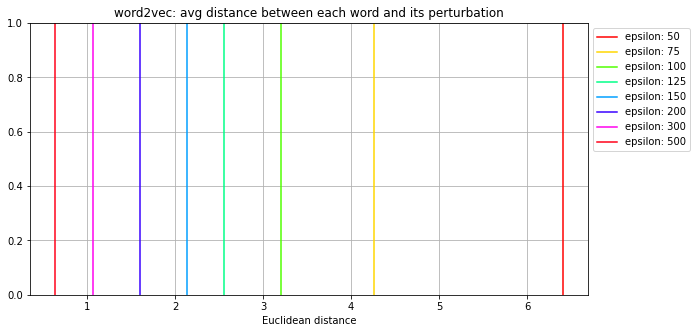

In [ ]:
plot_pertubations(avg_w2v_distances, epsilons, 'word2vec: avg distance between each word and its perturbation')

### fastText

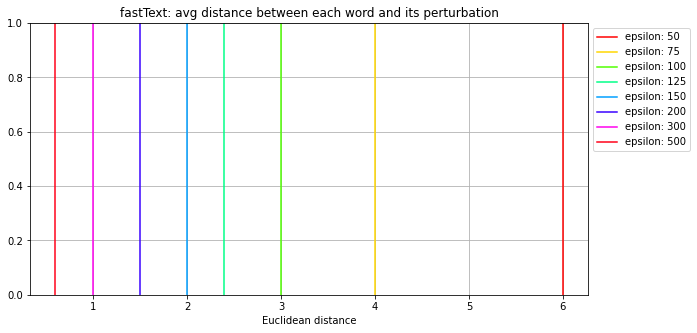

In [ ]:
plot_pertubations(avg_ft_distances, epsilons, 'fastText: avg distance between each word and its perturbation')

### BERT

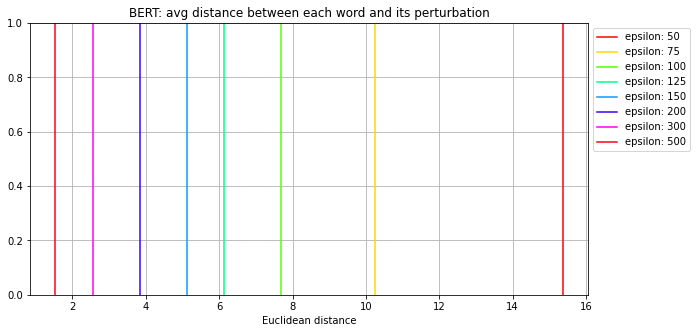

In [ ]:
plot_pertubations(avg_BERT_distances, epsilons, 'BERT: avg distance between each word and its perturbation')

## 5.2. Distance between original word and $k$ nearest neighbours

The second experiment is to compute the Euclidean distance between each word embedding and its $k$ nearest neighbours (without any pertubation). This gives us baseline of the average distance between words in the embedding space. We calculate this average for a set of chosen $k$ values to compare the results. We consider $k \in [1,2,3,4,5,10,20,50,200,500,1000]$.

In [ ]:
from pyspark import SparkFiles

def calculate_nn_dist(word, emb_model, local_vocab, local_k, local_embedding_dims):
  """
  Calculates the distance between a word and its k nearest neighbours.
  """
  from annoy import AnnoyIndex
  # load the annoy index to find nearest neighbours
  local_index = AnnoyIndex(embedding_dims, 'euclidean')
  if "word2vec" in emb_model:
    local_index.load(SparkFiles.get("M1_index_word2vec.ann"))
  elif "fastText" in emb_model:
    local_index.load(SparkFiles.get("M1_index_fastText.ann"))
  elif "BERT_static" in emb_model:
    local_index.load(SparkFiles.get("M1_index_BERT.ann"))
  elif "BERT_context" in emb_model:
    local_index.load(SparkFiles.get("M1_index_BERT_context.ann"))

  # obtain word index
  if "BERT_context" in emb_model:
    i = word
  else:
    i = local_vocab.stoi[word]

  # obtain nearest neighbours
  # use k+1, because k=1 corresponds to the item itself
  nns = local_index.get_nns_by_item(i, local_k+1, include_distances=True)

  # obtain total distance between the word and its nns
  total_dist = sum(nns[1])

  # obtain avg distance between the word and its nns
  avg_dist = total_dist / local_k

  return avg_dist

For the contextual case, we use a slightly different function.

In [ ]:
from pyspark import SparkFiles
from pyspark.sql import SparkSession

def all_nn_distances(words_list, emb_model, ann_filename, vocab, k, embedding_dims):
  """
  Computes the distance between each word and its k nearest neighbours and save this in a file.
  """
  # start sparksession
  spark = SparkSession.builder.config("spark.driver.memory", "15g").appName("privacy-experiment-1b").getOrCreate()

  # initialize title of experiment f
  title = emb_model + "_k_" + str(k)

  # parallelize data and obtain nn distances
  with spark.sparkContext as sc:
    sc.addFile(ann_filename)
    words = sc.parallelize(words_list, numSlices=500)

    # obtain nn distances for every word in emb model
    nn_distances = words.map(
        lambda word: calculate_nn_dist(word, emb_model, vocab, k, embedding_dims))  
    
    nn_distances_dir = join('gdrive/My Drive/Colab Data/MSc thesis/output/nn_distances/M1/', title)
    nn_distances.saveAsTextFile(nn_distances_dir)
  
  print("Experiment " + title + " Done!")

  return nn_distances_dir

Compute the average distances for each $k$.

In [ ]:
import glob
import os
import pandas as pd 

# set epsilon 
# k_list = [1,2,3,4,5,10,20,50,200,500,1000]
k_list = [2,3,4,5,10,20,50,200,500,1000]

avg_w2v_nn_distances = []
avg_ft_nn_distances = []
avg_BERT_nn_distances = []
avg_BERT_context_nn_distances = []

# perform get distances for set of epsilons
for k in k_list:

  # # word2vec ________________________
  # # set embedding model
  # emb_model = "word2vec"
  # embedding_dims = 320

  # # create the distances
  # w2v_nn_distances_dir = all_nn_distances(intersect_w2v, emb_model, w2v_ann_filename, w2v_vocab, k, embedding_dims)

  # # rename files 
  # rename_files(w2v_nn_distances_dir)

  # # return dataframe list by using a list comprehension
  # files = [pd.read_csv(file, names =['distance'] ) for file in glob.glob(os.path.join(w2v_nn_distances_dir ,"*.txt"))]
  # w2v_nn_distances = pd.concat(files).sum()[0]
  # avg_w2v_nn_distances.append(w2v_nn_distances)

  # # fastText ________________________
  # # set embedding model
  # emb_model = "fastText"
  # embedding_dims = 300

  # # create the distances
  # ft_nn_distances_dir = all_nn_distances(intersect_ft, emb_model, ft_ann_filename, ft_vocab, k, embedding_dims)

  # # rename files 
  # rename_files(ft_nn_distances_dir)

  # # return dataframe list by using a list comprehension
  # files = [pd.read_csv(file, names =['distance'] ) for file in glob.glob(os.path.join(ft_nn_distances_dir ,"*.txt"))]
  # ft_nn_distances = pd.concat(files).sum()[0]
  # avg_ft_nn_distances.append(ft_nn_distances)

  # BERT static ________________________
  # set embedding model
  emb_model = "BERT_static"
  embedding_dims = 768

  # create the distances
  BERT_nn_distances_dir = all_nn_distances(bertje_tokens, emb_model, BERT_ann_filename, BERT_vocab, k, embedding_dims)

  # rename files 
  rename_files(BERT_nn_distances_dir)

  # return dataframe list by using a list comprehension
  files = [pd.read_csv(file, names =['distance'] ) for file in glob.glob(os.path.join(BERT_nn_distances_dir ,"*.txt"))]
  BERT_nn_distances = pd.concat(files).sum()[0]
  avg_BERT_nn_distances.append(BERT_nn_distances)

  # BERT context ________________________
  # set embedding model
  emb_model = "BERT_context"
  embedding_dims = 768

  # make list of indices
  list_indices = [i for i in range(context_emb_tokens)]

  # create the distances
  BERT_context_nn_distances_dir = all_nn_distances(list_indices, emb_model, BERT_context_ann_filename, context_emb_tokens, k, embedding_dims)

  # rename files 
  rename_files(BERT_context_nn_distances_dir)

  # return dataframe list by using a list comprehension
  files = [pd.read_csv(file, names =['distance'] ) for file in glob.glob(os.path.join(BERT_context_nn_distances_dir ,"*.txt"))]
  BERT_context_nn_distances = pd.concat(files).sum()[0]
  avg_BERT_context_nn_distances.append(BERT_nn_distances)

# compute average
avg_w2v_nn_distances = np.array(avg_w2v_nn_distances) / len(intersect_w2v)
avg_ft_nn_distances = np.array(avg_ft_nn_distances) / len(intersect_ft)
avg_BERT_nn_distances = np.array(avg_BERT_nn_distances) / len(bertje_tokens)
avg_BERT_context_nn_distances = np.array(avg_BERT_context_nn_distances) / len(context_emb_tokens)

In [ ]:
# avg_w2v_nn_distances = [0.        , 0.49999943, 0.66666603, 0.74999925, 0.79999924,
#        0.89999917, 0.94999919, 0.97999918, 0.99499925, 0.99799928,
#        0.9989993 ]

avg_w2v_nn_distances

array([0.83237592, 0.84920673, 0.85698133, 0.86115258, 0.86473671,
       0.87981935, 0.89560698, 0.91824225, 0.95633046, 0.98406503,
       1.00665459])

In [ ]:
# avg_ft_nn_distances = [0.38991687, 0.40524812, 0.41758718, 0.41987748, 0.43731337,
#        0.44472837, 0.46802277, 0.49749396, 0.52801376, 0.53974752,
#        0.54497167]

avg_ft_nn_distances

array([0.67798348, 0.69307148, 0.69861815, 0.70116012, 0.70268817,
       0.71328129, 0.7226057 , 0.73507405, 0.75390291, 0.76272746,
       0.77010602])

In [ ]:
# avg_BERT_nn_distances = [1.00687039, 1.01074356, 1.02369813, 1.03674901, 1.04579382,
#        1.11309152, 1.11200009, 1.19304042, 1.29668088, 1.34354153,
#        1.37217044]

avg_BERT_nn_distances

array([1.40508702, 1.42690202, 1.44174152, 1.45242555, 1.46064785,
       1.47392728, 1.48625159, 1.50071869, 1.52655444, 1.54610204,
       1.56255515])

In [ ]:
avg_BERT_context_nn_distances

## 5.2.2. Visualize results

### word2vec

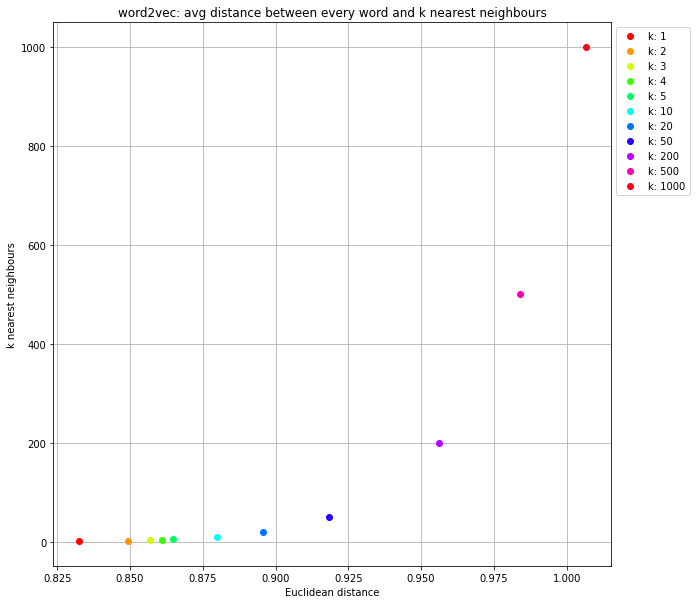

In [ ]:
plot_nn(avg_w2v_nn_distances, k_list, 'word2vec: avg distance between every word and k nearest neighbours')

### fastText

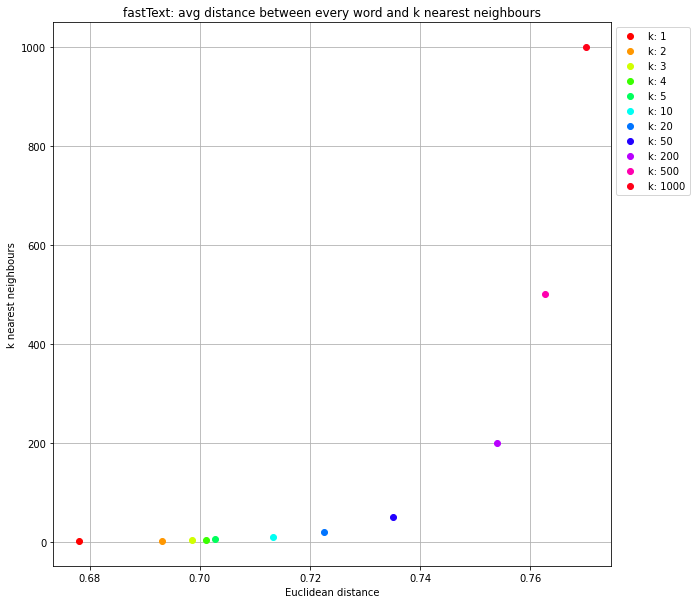

In [ ]:
plot_nn(avg_ft_nn_distances, k_list, 'fastText: avg distance between every word and k nearest neighbours')

### BERT

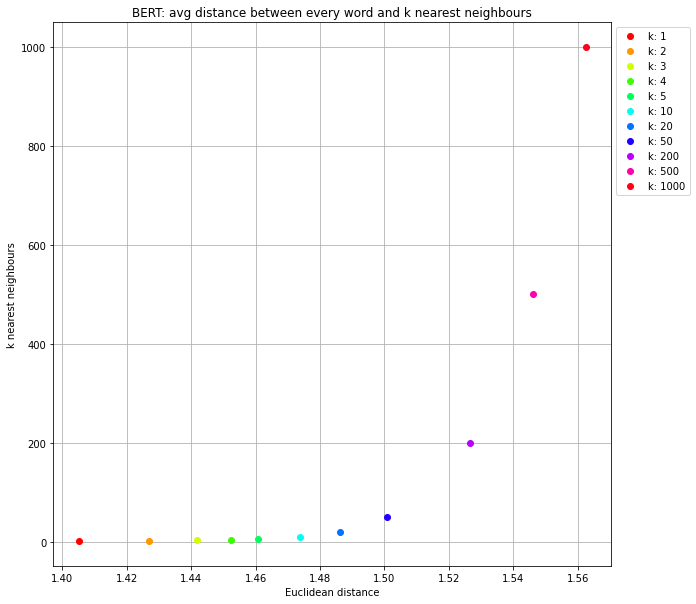

In [ ]:
plot_nn(avg_BERT_nn_distances, k_list, 'BERT: avg distance between every word and k nearest neighbours')

In [ ]:
plot_nn(avg_BERT_context_nn_distances, k_list, 'BERT context: avg distance between every word and k nearest neighbours')

# 6. Plausible Deniability Statistics

In order to characterize the ability of an adversary to recover the original input text when observing the perturbed text, we compute two statistics. These statistics measure the level of [plausible deniability](https://arxiv.org/abs/1708.07975#:~:text=This%20paper%20presents%20a%20criterion,up%20to%20a%20privacy%20parameter.).

An intuitive explanation of both statistics is as follows:
* $N_w$: the probability of an input token $w$ not modified by the privatization algorithm.
* $S_w$: the number of distinct possible output tokens of the privatization algorithm given an input token $w$.

The follow code snippet give an illustration of the mechanism that we're gonna use.

In [ ]:
import pandas as pd
from collections import Counter

def count_replacements(word, vocab, ann_index, epsilon, embedding_dims, num_replacements=1000):
  """
  Function to count the replacements for one word.
  """
  replacement_counter = Counter()
  for i in range(num_replacements):
      replacement_counter[replace_word(word, vocab, ann_index, epsilon, embedding_dims)] += 1
  percentages = [count/num_replacements for count in sorted(replacement_counter.values(), reverse=True)]
  counts = pd.DataFrame(replacement_counter.most_common(), columns=["Word", "Count"])
  counts['Ratio'] = percentages

  return counts

In [ ]:
count_replacements(word="Parijs", vocab=w2v_vocab, ann_index=w2v_ann_index, epsilon=150, embedding_dims=320).head(10)

,Word,Count,Ratio
0,parijs,429,0.429
1,straatsburg,27,0.027
2,parijse,15,0.015
3,brussel,9,0.009
4,paris,9,0.009
5,bordeaux,9,0.009
6,versailles,6,0.006
7,frankrijk,6,0.006
8,sorbonne,5,0.005
9,uitnodiging,5,0.005


In [ ]:
count_replacements(word="Parijs", vocab=ft_vocab, ann_index=ft_ann_index, epsilon=150, embedding_dims=300).head(10)

,Word,Count,Ratio
0,Parijs,260,0.260
1,Londen,51,0.051
2,Milaan,11,0.011
3,Bordeaux,7,0.007
4,Montmartre,6,0.006
5,Genève,6,0.006
6,Avignon,6,0.006
7,Madrid,6,0.006
8,Utrecht,5,0.005
9,Lissabon,5,0.005


In [ ]:
count_replacements(word="Parijs", vocab=BERT_vocab, ann_index=BERT_ann_index, epsilon=150, embedding_dims=768).head(10)

,Word,Count,Ratio
0,Parijs,285,0.285
1,Frankrijk,25,0.025
2,Amsterdam,12,0.012
3,Franse,11,0.011
4,Londen,9,0.009
5,<unk>,6,0.006
6,Europa,5,0.005
7,Berlijn,5,0.005
8,Barcelona,5,0.005
9,huis,4,0.004


In [ ]:
import pandas as pd
from collections import Counter

def count_replacements_context(word_vec, context_emb_tokens, ann_index, epsilon, embedding_dims, num_replacements=1000):
  """
  Function to count the replacements for one word.
  """
  replacement_counter = Counter()
  for i in range(num_replacements):
      replacement_counter[replace_word_context(word_vec, context_emb_tokens, ann_index, epsilon, embedding_dims)] += 1
  percentages = [count/num_replacements for count in sorted(replacement_counter.values(), reverse=True)]
  counts = pd.DataFrame(replacement_counter.most_common(), columns=["Word", "Count"])
  counts['Ratio'] = percentages

  return counts

In [ ]:
indices = [i for i, x in enumerate(context_emb_tokens) if x == "Parijs"]
word_vec = BERT_context_ann_index.get_item_vector(indices[0])

In [ ]:
count_replacements_context(word_vec, context_emb_tokens, ann_index=BERT_context_ann_index, epsilon=10, embedding_dims=768).head(10)

,Word,Count,Ratio
0,Parijs,134,0.134
1,Frankrijk,27,0.027
2,Amsterdam,16,0.016
3,Londen,15,0.015
4,hem,11,0.011
5,boeken,10,0.010
6,wereld,9,0.009
7,Franse,9,0.009
8,vriend,7,0.007
9,leven,6,0.006


We can generalize this principle to a function that computes the statistics that we need. 

In [ ]:
from pyspark import SparkFiles

def get_pd_stats(word, ann_filename, local_vocab, local_epsilon, local_embedding_dims, num_replacements=1000):
  """
  Obtain plausible deniability statistics for a given word.
  """
  from annoy import AnnoyIndex
  import pandas as pd 
  # load the annoy index to find nearest neighbours
  local_index = AnnoyIndex(embedding_dims, 'euclidean')
  if "word2vec" in emb_model:
    local_index.load(SparkFiles.get("M1_index_word2vec.ann"))
  elif "fastText" in emb_model:
    local_index.load(SparkFiles.get("M1_index_fastText.ann"))
  elif "BERT" in emb_model:
    local_index.load(SparkFiles.get("M1_index_BERT.ann"))
  elif "BERT_context" in emb_model:
    local_index.load(SparkFiles.get("M1_index_BERT_context.ann"))

  # pd stats for the contextual model
  if "BERT_context" in emb_model:
    # obtain the word index and vector
    index = word
    word_vec = local_index.get_item_vector(index)

    # perform 1000 replacements with the algorithm on word
    replacement_counter = Counter()
    for j in range(num_replacements):
      replacement_counter[replace_word_context(word_vec, context_emb_tokens, local_index, local_epsilon, embedding_dims)] += 1
  # pd stats for the static models
  else:
    # perform 1000 replacements with the algorithm on word
    replacement_counter = Counter()
    for j in range(num_replacements):
      replacement_counter[replace_word(word, local_vocab, local_index, local_epsilon, embedding_dims)] += 1

  # make dataframe to illustrate perturbed word and occurance rate (count)
  counts = pd.DataFrame(replacement_counter.most_common(), columns=["Word", "Count"])

  # compute N_w (number of not perturbed words actually)
  if word in counts['Word'].values:
    N_w = counts.loc[counts["Word"] == word].iloc[0]["Count"]
  else:
    N_w = 0

  # compute S_w
  S_w = len(counts)

  return (N_w, S_w)

The following function computes all the pd statistics.

In [ ]:
from pyspark import SparkFiles
from pyspark.sql import SparkSession

def all_pd_stats(words_list, emb_model, ann_filename, vocab, epsilon, embedding_dims): 
  # start sparksession
  spark = SparkSession.builder.config("spark.driver.memory", "15g").appName("privacy-experiment-2").getOrCreate()

  # initialize title of experiment 
  title = emb_model + "_epsilon_" + str(epsilon)

  # parallelize data and obtain stats
  with spark.sparkContext as sc:
    sc.addFile(ann_filename)
    words = sc.parallelize(words_list, numSlices=500)
    
    # obtain plausible deniability statistics for every word in emb model 
    pd_stats = words.map(
        lambda word: get_pd_stats(word, emb_model, vocab, epsilon, embedding_dims))  

    
    pd_stats_dir = join('gdrive/My Drive/Colab Data/MSc thesis/output/pd_stats/M1/', title)
    pd_stats.saveAsTextFile(pd_stats_dir)

  print("Experiment " + title + " Done!")

  return pd_stats_dir

We calculate these statistics for a set of chosen ϵ values to compare the results.

In [ ]:
import glob
import os
import pandas as pd 

# set epsilon 
epsilons = [50, 75, 100, 125, 150, 200, 300, 500]
# epsilons = [5, 10, 15, 25, 50]

w2v_pd_stats_list = []
ft_pd_stats_list = []
BERT_pd_stats_list =[]
BERT_context_pd_stats_list = []

# perform get distances for set of epsilons
for epsilon in epsilons:

  # # word2vec ________________________
  # # set embedding model
  # emb_model = "word2vec"
  # embedding_dims = 320

  # # create the distances
  # w2v_pd_stats_dir = all_pd_stats(intersect_w2v, emb_model, w2v_ann_filename, w2v_vocab, epsilon, embedding_dims)

  # # rename files 
  # rename_files(w2v_pd_stats_dir)

  # # return dataframe list by using a list comprehension
  # files = [pd.read_csv(file, names =['(N_w, S_w)']) for file in glob.glob(os.path.join(w2v_pd_stats_dir ,"*.txt"))]
  # w2v_pd_stats = pd.concat(files)
  # w2v_pd_stats_list.append(w2v_pd_stats)

  # # fastText ________________________
  # # set embedding model
  # emb_model = "fastText"
  # embedding_dims = 300

  # # create the distances
  # ft_pd_stats_dir = all_pd_stats(intersect_ft, emb_model, ft_ann_filename, ft_vocab, epsilon, embedding_dims)

  # # rename files 
  # rename_files(ft_pd_stats_dir)

  # # return dataframe list by using a list comprehension
  # files = [pd.read_csv(file, names =['(N_w, S_w)']) for file in glob.glob(os.path.join(ft_pd_stats_dir ,"*.txt"))]
  # ft_pd_stats = pd.concat(files)
  # ft_pd_stats_list.append(ft_pd_stats)

  # BERT static ________________________
  # set embedding model
  emb_model = "BERT_static"
  embedding_dims = 768

  # create the distances
  BERT_pd_stats_dir = all_pd_stats(bertje_tokens, emb_model, BERT_ann_filename, BERT_vocab, epsilon, embedding_dims)

  # rename files 
  rename_files(BERT_pd_stats_dir)

  # return dataframe list by using a list comprehension
  files = [pd.read_csv(file, names =['(N_w, S_w)']) for file in glob.glob(os.path.join(BERT_pd_stats_dir ,"*.txt"))]
  BERT_pd_stats = pd.concat(files)
  BERT_pd_stats_list.append(BERT_pd_stats)

  # # BERT context ________________________
  # # set embedding model
  # emb_model = "BERT_context"
  # embedding_dims = 768

  # make list of indices
  list_indices = [i for i in range(context_emb_tokens)]

  # # create the distances
  # BERT_context_pd_stats_dir = all_pd_stats(list_indices, emb_model, BERT_context_ann_filename, context_emb_tokens, epsilon, embedding_dims)

  # # rename files 
  # rename_files(BERT_context_pd_stats_dir)

  # # return dataframe list by using a list comprehension
  # files = [pd.read_csv(file, names =['(N_w, S_w)']) for file in glob.glob(os.path.join(BERT_context_pd_stats_dir ,"*.txt"))]
  # BERT_context_pd_stats = pd.concat(files)
  # BERT_context_pd_stats_list.append(BERT_context_pd_stats)

Py4JJavaError: ignored

In [ ]:
import pandas as pd
import glob
import os

w2v_pd_stats_dir = 'gdrive/My Drive/Colab Data/MSc thesis/output/pd_stats/M1/word2vec_epsilon_50/'
  
# return dataframe list by using a list comprehension
files = [pd.read_csv(file, names =['(N_w, S_w)']) for file in glob.glob(os.path.join(w2v_pd_stats_dir ,"*.txt"))]
w2v_pd_stats = pd.concat(files)

In [ ]:
N_w_list = []
S_w_list = []
for row in w2v_pd_stats.iterrows():
  N_w = int(row[0].replace("(", "").strip())
  S_w = int(row[1][0].replace(")", "").strip())
  N_w_list.append(N_w)
  S_w_list.append(S_w)

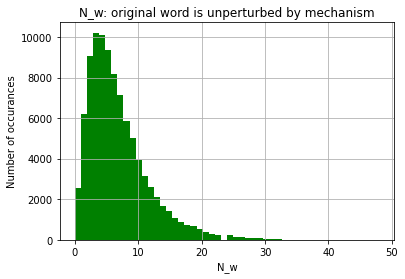

In [ ]:
# the histogram of the data
n, bins, patches = plt.hist(N_w_list, 50, facecolor='g')

plt.xlabel('N_w')
plt.ylabel('Number of occurances')
plt.title('N_w: original word is unperturbed by mechanism')
plt.grid(True)
plt.show()

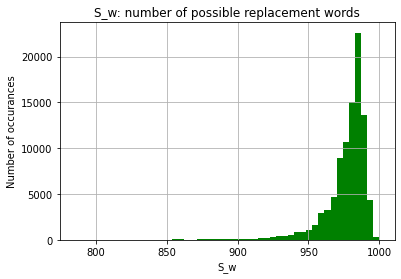

In [ ]:
# the histogram of the data
n, bins, patches = plt.hist(S_w_list, 50, facecolor='g')

plt.xlabel('S_w')
plt.ylabel('Number of occurances')
plt.title('S_w: number of possible replacement words')
plt.grid(True)
plt.show()

# Random Snippet

## Make complete data file

We have to convert the original 90-10 split of the data from two .txt files to a .csv file for later use (torchtext.data.TabularData() only takes .csv files).

In [ ]:
# import pandas as pd 
# from pathlib import Path 

# # define function to create data frame
# def create_df(train_or_test):
#     # check input
#     if train_or_test != 'train' and train_or_test != 'test':
#         raise TypeError("ERROR: Wrong input for 'train_or_test'. It should have the value of 'train' or 'test'.")
    
#     # create dataframe with reviews and labels
#     df = pd.read_table('gdrive/My Drive/Colab Data/MSc thesis/dbrd_preprocessed/' + train_or_test + ".labels.txt", header=None, names=['labels'])
#     df['sentence'] = pd.read_table('gdrive/My Drive/Colab Data/MSc thesis/dbrd_preprocessed/' + train_or_test + ".sentences.txt", header=None, names=['sentence'])
    
#     return df

# # make dataframe with all data
# df_train = create_df('train')
# df_test = create_df('test')
# frames = [df_train, df_test]
# df = pd.concat(frames)

# # convert to csv and save
# filepath = Path('gdrive/My Drive/Colab Data/MSc thesis/dbrd_preprocessed/complete_data.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)  
# df.to_csv(filepath) 

## PD stats function

In [ ]:
# for word in intersect_words:
#   # perform 1000 replacements with the algorithm on word
#   replacement_counter = Counter()
#   for j in range(1000):
#     replacement_counter[replace_word(word, w2v_vocab, w2v_ann_index, 50, 320)] += 1

#   # make dataframe to illustrate perturbed word and occurance rate (count)
#   counts = pd.DataFrame(replacement_counter.most_common(), columns=["Word", "Count"])
#   if word in counts['Word'].values:
#     # compute N_w (number of not perturbed words actually)
#     N_w = counts.loc[counts["Word"] == word].iloc[0]["Count"]
#   else: 
#     N_w = 0

#   # compute S_w
#   S_w = len(counts)

#   print(N_w, S_w)

In [ ]:
# from torchtext.legacy.vocab import Vectors

# # attach fastText embeddings
# vectors_BERT = Vectors('gdrive/My Drive/Colab Data/MSc thesis/BERT/static_BERT_vec.txt')

In [ ]:
# words_list_BERT = []
# for i in range(vectors_BERT.__len__()):
#   words_list_BERT.append(vectors_BERT.itos[i])
# len(words_list_BERT)

In [ ]:
# x = reviews[0].review
# y = " ". join(x)
# epsilon = 25

# # make ordered dictionary to keep track of the position of each word
# sensitive_tokens = OrderedDict()

# # initialize private sentence
# private_sent = []

# # obtain contexual BERT embeddings
# tokenized_text, tokens_tensor, segments_tensor = bert_text_preparation(y, tokenizer)
# list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensor, model)

# # loop over tokens in sensitive sentence
# for sensitive_token in tokenized_text[1:-1]:
#   # keep track of position of word and whether it occurs multiple times
#   if sensitive_token in sensitive_tokens:
#     sensitive_tokens[sensitive_token] += 1
#   else:
#     sensitive_tokens[sensitive_token] = 1

#   # compute the position of the current token
#   token_indices = [i for i, token in enumerate(tokenized_text) if token == sensitive_token]
#   current_index = token_indices[sensitive_tokens[sensitive_token]-1]

#   # get the corresponding embedding
#   sensitive_vec = list_token_embeddings[current_index]

#   # privatize word
#   privatized_word = replace_word_context(sensitive_vec, bertje, BERT_ann_index, epsilon, 768)
#   private_sent.append(privatized_word)

# print("Original sentence: ", y)
# print("Privatized sentence: ", " ".join(private_sent))
# print("\n")

In [ ]:
# intersect_words = list(set(words_list_ft).intersection(words_list_w2v))
# len(intersect_words)

For the contextual case, we use a slightly different version:

In [ ]:
# from pyspark import SparkFiles

# def get_pd_stats_context(word, ann_filename, context_emb_tokens, local_epsilon, local_embedding_dims, num_replacements=1000):
#   """
#   Obtain plausible deniability statistics for a given word.
#   """
#   from annoy import AnnoyIndex
#   import pandas as pd 
#   # load the annoy index to find nearest neighbours
#   local_index = AnnoyIndex(embedding_dims, 'euclidean')
#   if "BERT_context" in emb_model:
#     local_index.load(SparkFiles.get("M1_index_BERT_context.ann"))

#   # obtain the word index and vector
#   index = context_emb_tokens.index(word)
#   word_vec = local_index.get_item_vector(index)

#   # perform 1000 replacements with the algorithm on word
#   replacement_counter = Counter()
#   for j in range(num_replacements):
#     replacement_counter[replace_word_context(word_vec, context_emb_tokens, local_index, local_epsilon, embedding_dims)] += 1

#   # make dataframe to illustrate perturbed word and occurance rate (count)
#   counts = pd.DataFrame(replacement_counter.most_common(), columns=["Word", "Count"])

#   # compute N_w (number of not perturbed words actually)
#   if word in counts['Word'].values:
#     N_w = counts.loc[counts["Word"] == word].iloc[0]["Count"]
#   else:
#     N_w = 0

#   # compute S_w
#   S_w = len(counts)

#   return (N_w, S_w)